In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3814 - rounded_accuracy: 0.8487 - val_loss: 0.3169 - val_rounded_accuracy: 0.8998
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3083 - rounded_accuracy: 0.9126 - val_loss: 0.3021 - val_rounded_accuracy: 0.9200
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2997 - rounded_accuracy: 0.9204 - val_loss: 0.2982 - val_rounded_accuracy: 0.9206
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2959 - rounded_accuracy: 0.9240 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2928 - rounded_accuracy: 0.9269 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9283 - val_loss: 0.2916 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

# Visualizing the Reconstruction

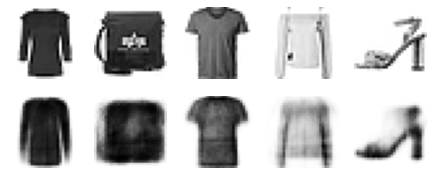

In [7]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1+n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)        

# Visualizing the Fashion MNIST Dataset

In [8]:
from sklearn.manifold import TSNE

In [9]:
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

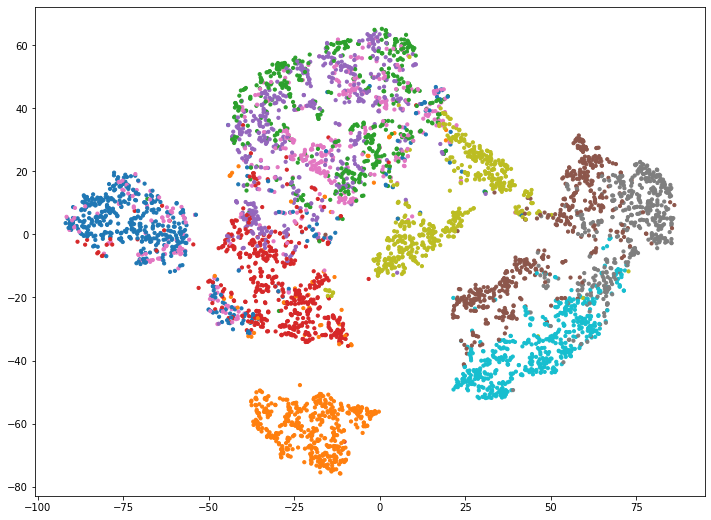

In [10]:
plt.figure(figsize=(12, 9))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')

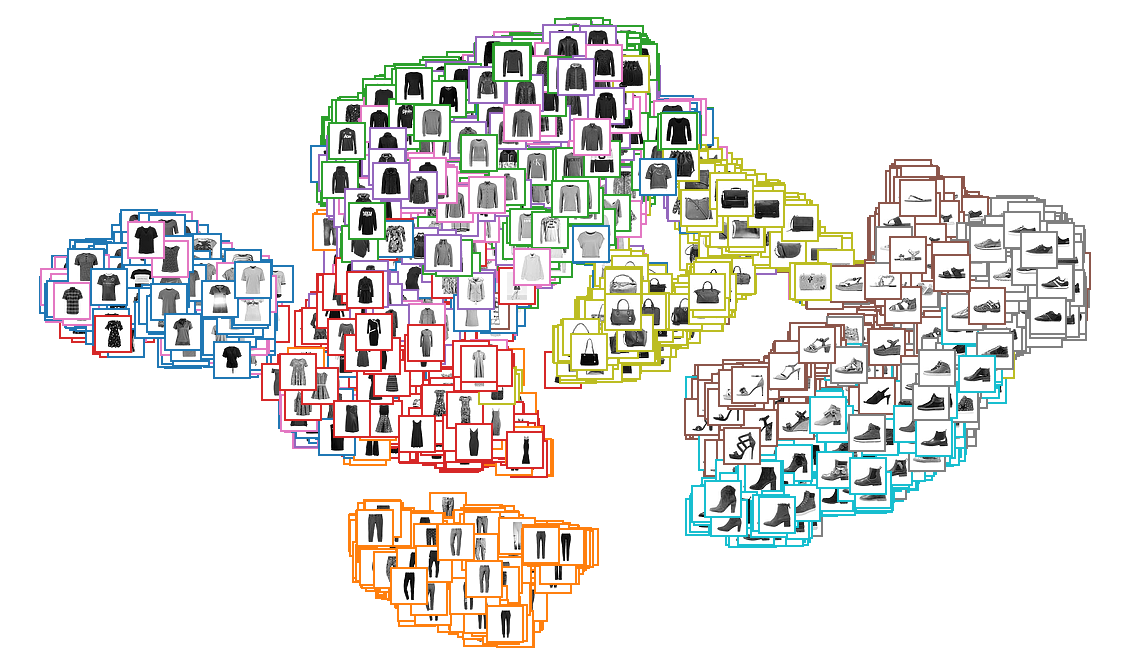

In [12]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(20, 12))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()